# Benchmark

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from fastpynuts.fastpynuts import NUTSfinderBenchmark as NUTSfinder

# other
from nuts_finder import NutsFinder

In [2]:
from IPython.display import HTML

def compare_geoms(*geoms):
    html = "".join([geom._repr_svg_() for geom in geoms])
    return HTML(html)

In [3]:
import time

scales = ["01", "03", "10", "20", "60"]
max_levels = [0, 1, 2, 3]

## Benchmark Init Times

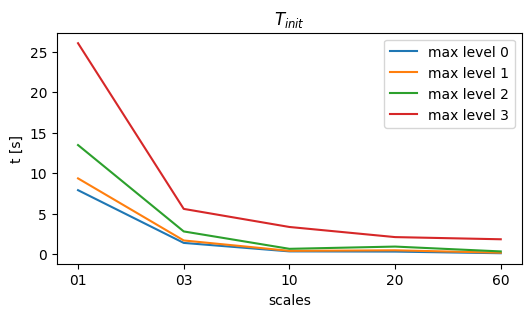

In [4]:
times_init = []
finders = []
x = range(len(scales))
plt.figure(figsize=(6,3))
for ml_ in max_levels:
    times_init_ = []
    finders_ = []
    for scale in scales:
        t0 = time.time()
        mnf = NUTSfinder(f"data/NUTS_RG_{scale}M_2021_4326.geojson", max_level=ml_)
        finders_.append(mnf)
        times_init_.append(time.time()-t0)
    plt.plot(x, times_init_, label=f"max level {ml_}")
    plt.title("$T_{init}$")
    plt.xlabel("scales")
    plt.ylabel("t [s]")
    plt.xticks(x, scales)

    times_init.append(times_init_)
    finders.append(finders_)

plt.legend()


## Benchmark Initialization Steps

In [5]:
import re

import cProfile

from io import StringIO
from pstats import Stats

# utilities
def get_stats(pr, *args, sortargs=[], verbose=True, **kwargs):
    stream = StringIO()
    stat = Stats(pr, stream=stream)
    if sortargs:
        stat.sort_stats(*sortargs).print_stats(*args, **kwargs)
    else:
        stat.print_stats(*args, **kwargs)

    value = stream.getvalue()
    if verbose: print(value)
    return value


def parse_lines(bench):
    lines = re.findall("(\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(.+):(\d+)\((\w+)\)", bench, re.MULTILINE)
    parsed = [{key:val for key, val in zip(["ncalls", "tottime", "percall", "cumtime", "percall2", "file", "line", "fun"], line)} for line in lines]
    return parsed


def get_obj_name(parsed):
    with open(parsed["file"], "r") as f:
        class_n = []
        classes = []
        for num, line in enumerate(f, 1):
            if match := re.search("\w*class (.+?)([(].*:|:)", line):
                classes.append(match.group(1))
                class_n.append(num)

    target_line = int(parsed["line"])
    obj_name = [cl_ for n_, cl_ in zip(class_n, classes) if n_ < target_line][-1]
    return obj_name


def plot_benchmark(pr, *funs, axs=None):
    filter_funs = "|".join(funs)
    bench = get_stats(pr, "fastpynuts", filter_funs, sortargs=["cumtime"], verbose=False)

    parsed = parse_lines(bench)

    # replace inits
    for parsed_ in parsed:
        if parsed_["fun"] == "__init__":
            parsed_["fun"] = get_obj_name(parsed_)

    if axs is None: fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    ax, ax_rel = axs
    for i, info in enumerate(parsed):
        ax.bar(i, float(info["cumtime"]), label=" " + info["fun"])
        ax.set_title("Total Time")
        ax_rel.bar(i, float(info["percall2"]), label=" " + info["fun"])
        ax_rel.set_title("Time/Call")

    ax.set_xticks(range(len(parsed)), [p_["fun"] for p_ in parsed], rotation=30)
    ax_rel.set_xticks(range(len(parsed)), [p_["fun"] for p_ in parsed], rotation=30)

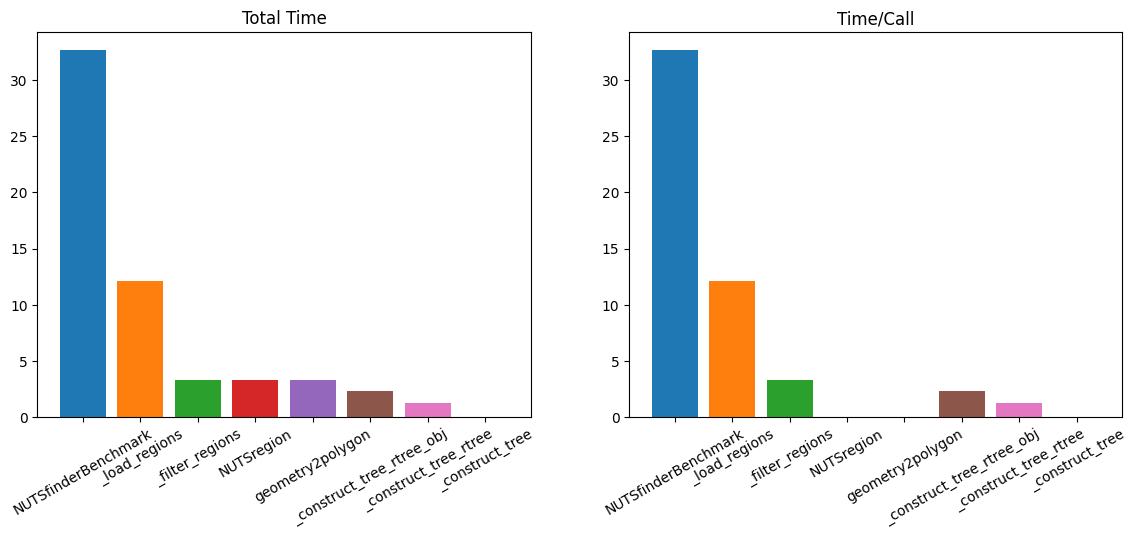

In [6]:
with cProfile.Profile() as pr: mnf_ = NUTSfinder(f"data/NUTS_RG_01M_2021_4326.geojson", max_level=ml_)
plot_benchmark(pr, "__init__", "_load_regions", "_construct_r_tree", "_construct_tree", "_filter_regions", "geometry2polygon" )

## Query Runtime Comparison

Comparing the runtime of the different finding strategies:
- R-Tree
- Tree
- Polygon
- Bbox

Text(0.5, 0.98, 'Query Runtime')

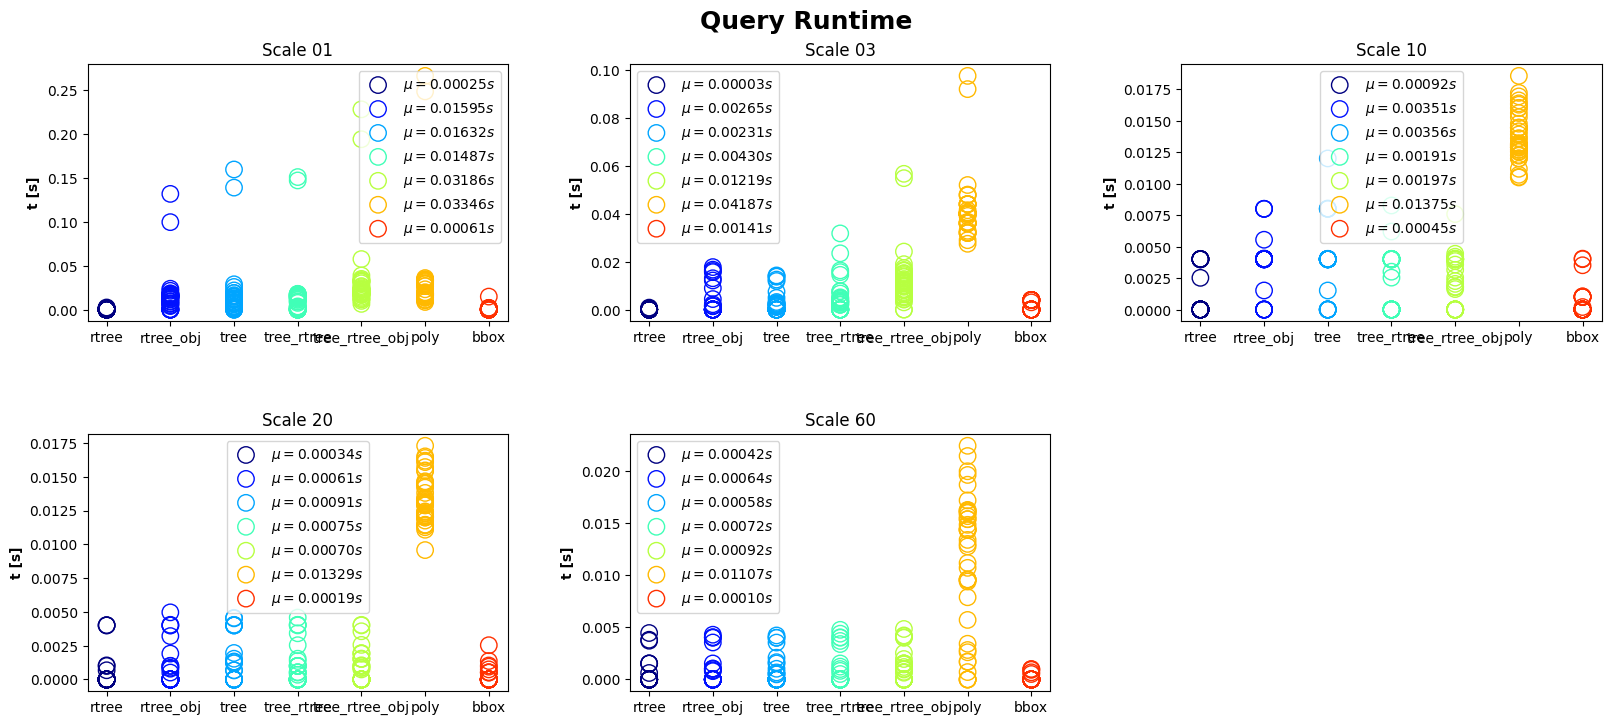

In [7]:
# benchmark settings
N_samples = 100
strategies = ["rtree", "rtree_obj", "tree", "tree_rtree", "tree_rtree_obj", "poly", "bbox"]
bounds = [-20.7, 36.4, 36.5, 62.1]

scale = 1
year = 2021
max_level = 3

labels = ["rtree", "rtree_obj", "tree", "tree_rtree", "tree_rtree_obj", "poly", "bbox"]


# run benchmark
x = np.random.uniform(bounds[0], bounds[2], N_samples)
y = np.random.uniform(bounds[1], bounds[3], N_samples)


fig = plt.figure(layout="constrained", figsize=(16, 10))
gs = GridSpec(3, 3, figure=fig, hspace=0.2, wspace=0.1)

durations = []
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(strategies))

for gs_, scale, finder in zip(gs, scales, finders[max_levels.index(max_level)]):
    ax = fig.add_subplot(gs_)

    for i, strategy in enumerate(strategies):
        durations_ = []
        for x_, y_ in zip(x, y):
            color = matplotlib.cm.jet(norm(i))

            t0 = time.time()
            hits = finder.find(x_, y_, method=strategy)
            if not hits: continue
            t1 = time.time()

            duration = t1-t0
            durations_.append(duration)

            scatter = ax.scatter(i, duration, 140, edgecolor=color, facecolor="none", label="_no_label")

        if durations_:
            avg = sum(durations_)/len(durations_)
        else:
            continue
        scatter.set_label(f"$\mu = {avg:.5f} s$")

        durations.append(durations_)

    ax.set_title(f"Scale {scale}")
    # ax.set_xlabel("method", fontweight="bold")
    ax.set_ylabel("t [s]", fontweight="bold")
    ax.set_xticks(range(len(labels)), labels)
    ax.legend()

plt.suptitle("Query Runtime", fontsize=18, fontweight="bold")


In [9]:
from shapely.algorithms.polylabel import polylabel


def create_random_points(shape, N):

    try:
        cpi = polylabel(shape)
        coords = shape.exterior.coords
    except:
        # for MultiPolygon, take a random part
        poly = np.random.choice(shape.geoms, 1)[0]
        cpi = polylabel(poly)
        coords = poly.exterior.coords
    point = (cpi.x, cpi.y)

    idxs = np.random.choice(len(coords), N)
    ps = [coords[int(idx)] for idx in idxs]
    dists = np.random.uniform(size=N)

    points = []
    for p_, dist_ in zip(ps, dists):
        dx, dy = point[0] - p_[0], point[1] - p_[1]
        points.append([point[0] - dist_*dx, point[1] - dist_*dy])

    return points


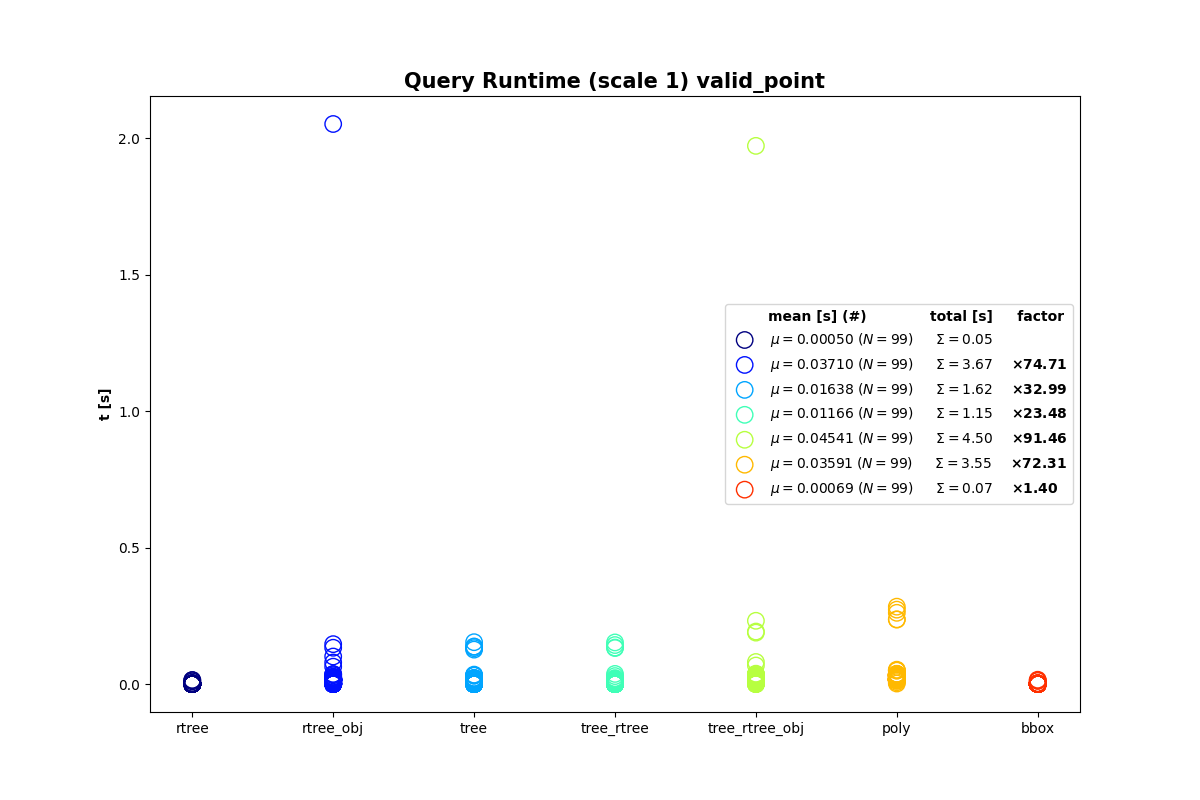

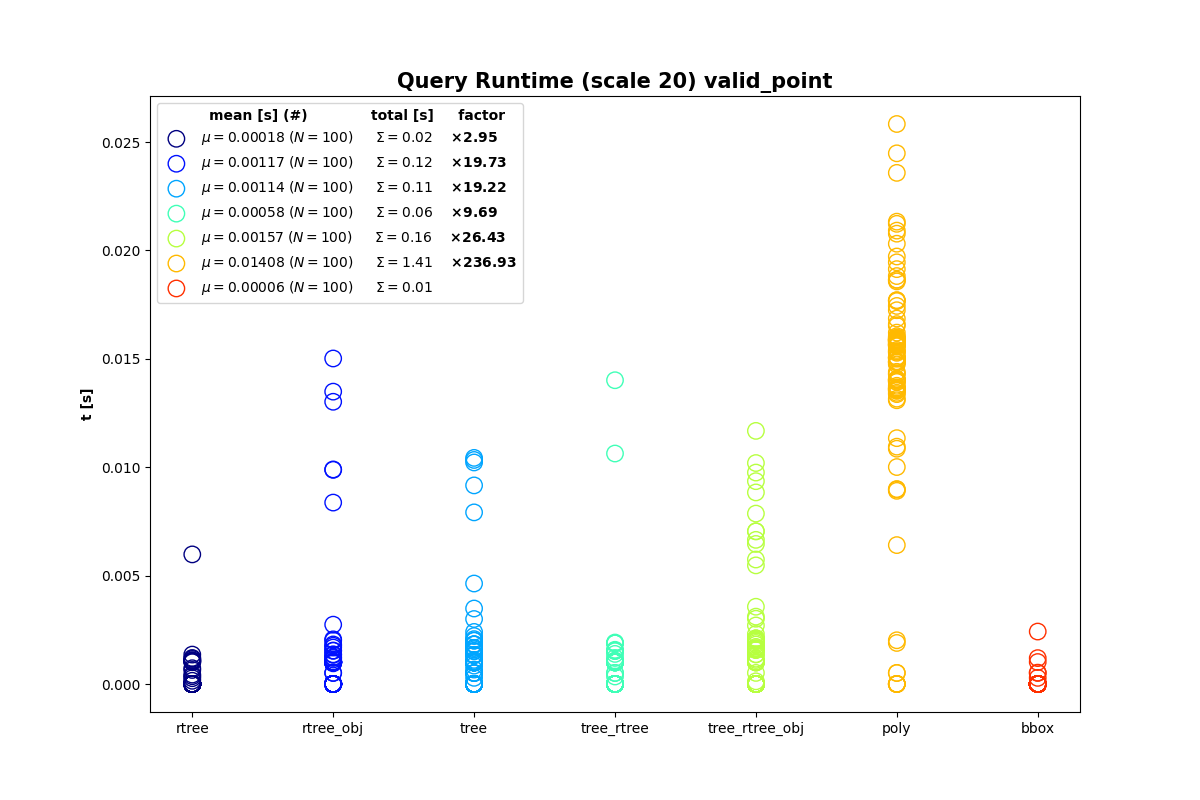

In [34]:
from nuts_finder import NutsFinder

import time
import numpy as np


%matplotlib widget

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def benchmark_strategies(nf, N_samples=100, valid_point=True, warmup=10, strategies=["rtree", "rtree_obj", "tree", "tree_rtree", "tree_rtree_obj", "poly", "bbox"], bounds=[-20.7, 36.4, 36.5, 62.1]):

    points = []
    for region in np.random.choice(nf, N_samples+warmup): points.extend(create_random_points(region.geom, 1))
    x = [p[0] for p in points]
    y = [p[1] for p in points]

    plt.figure(figsize=(12, 8))
    durations = []
    scatters = []
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(strategies))

    for i, strategy in enumerate(strategies):
        durations_ = []
        for j, (x_, y_) in enumerate(zip(x, y)):
            color = matplotlib.cm.jet(norm(i))

            t0 = time.time()
            if strategy.startswith("_"):
                hits = vars()["nf_nuts_finder"].find(lon=x_, lat=y_)
            else:
                hits = nf.find(x_, y_, method=strategy, valid_point=valid_point)
            if not hits: continue
            if j < warmup: continue
            t1 = time.time()

            duration = t1-t0
            durations_.append(duration)

            scatter = plt.scatter(i, duration, 140, edgecolor=color, facecolor="none", label="_no_label")

        if not durations_: continue

        scatters.append(scatter)
        durations.append(durations_)

    min_time = max([min([sum(durations_) for durations_ in durations]), 1e-7])
    for durations_, scatter_ in zip(durations, scatters):
        avg = sum(durations_)/len(durations_)
        if sum(durations_) == min_time:
            scatter_.set_label(f"$\mu = {avg:.5f} \; (N={len(durations_)}) \;\;\;\;\;\; \Sigma = {sum(durations_):6.2f}$")
        else:
            scatter_.set_label(f"$\mu = {avg:.5f} \; (N={len(durations_)}) \;\;\;\;\;\; \Sigma = {sum(durations_):6.2f} \;\;\;\;\; \\mathbf{{\\times  {sum(durations_)/min_time: 6.2f}}}$")


    plt.title(f"Query Runtime (scale {nf.scale})" + (f" valid_point" if valid_point else ""), fontweight="bold", fontsize=15)
    plt.ylabel("t [s]", fontweight="bold")
    plt.xticks(range(len(strategies)), [st_ if not st_.startswith("_") else st_[1:] for st_ in strategies])
    plt.legend(title="       mean [s] (#)             total [s]     factor", title_fontproperties={"weight": "bold"})


N = 1000
benchmark_strategies(finders[max_levels.index(max_level)][scales.index("01")], N_samples=N)
benchmark_strategies(finders[max_levels.index(max_level)][scales.index("20")], N_samples=N)

and other NUTS packages:
- [Nuts-Finder](https://github.com/nestauk/nuts_finder)

In [39]:
def get_nuts_finder(scale, year, retries=30):
    for try_ in range(retries):
        try: return NutsFinder(scale=int(scale), year=year)
        except: pass

other_nuts_finder = {scale: get_nuts_finder(scale, 2021) for scale in scales}

Text(0.5, 0.98, 'Query Runtime')

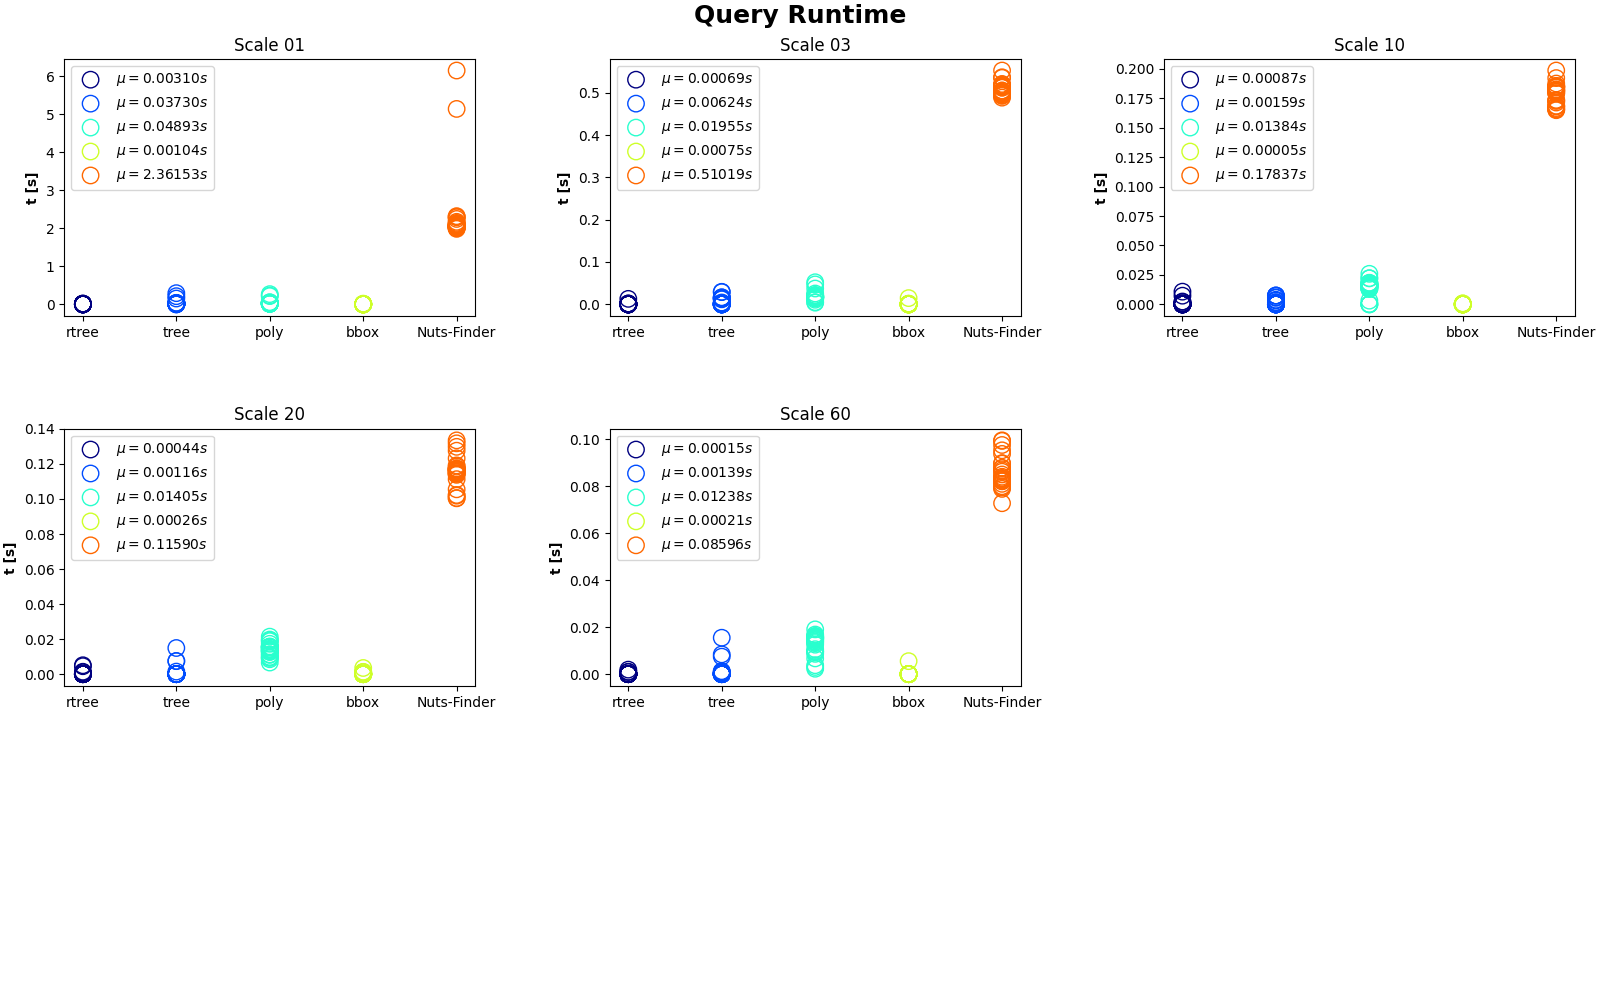

In [42]:
# benchmark settings
N_samples = 100
strategies = ["rtree", "tree", "poly", "bbox", "_other_nuts_finder"]
bounds = [-20.7, 36.4, 36.5, 62.1]

scale = 1
year = 2021
max_level = 3

labels = ["rtree", "tree", "poly", "bbox", "Nuts-Finder"]


# run benchmark
x = np.random.uniform(bounds[0], bounds[2], N_samples)
y = np.random.uniform(bounds[1], bounds[3], N_samples)


fig = plt.figure(layout="constrained", figsize=(16, 10))
gs = GridSpec(3, 3, figure=fig, hspace=0.2, wspace=0.1)

durations = []
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(strategies))

for gs_, scale, finder in zip(gs, scales, finders[max_levels.index(max_level)]):
    ax = fig.add_subplot(gs_)

    for i, strategy in enumerate(strategies):
        durations_ = []
        for x_, y_ in zip(x, y):
            color = matplotlib.cm.jet(norm(i))

            t0 = time.time()
            if strategy.startswith("_"):
                hits = vars()[strategy[1:]][scale].find(lon=x_, lat=y_)
            else:
                hits = finder.find(x_, y_, method=strategy)
            if not hits: continue
            t1 = time.time()

            duration = t1-t0
            durations_.append(duration)

            scatter = ax.scatter(i, duration, 140, edgecolor=color, facecolor="none", label="_no_label")

        if durations_:
            avg = sum(durations_)/len(durations_)
        else:
            continue
        scatter.set_label(f"$\mu = {avg:.5f} s$")

        durations.append(durations_)

    ax.set_title(f"Scale {scale}")
    # ax.set_xlabel("method", fontweight="bold")
    ax.set_ylabel("t [s]", fontweight="bold")
    ax.set_xticks(range(len(labels)), labels)
    ax.legend()

plt.suptitle("Query Runtime", fontsize=18, fontweight="bold")


For a few selected points, run the query for multiple maximum NUTS levels. Also determine if the results if the results of different scales are equal for the maximum scale.

## Runtime when skipping validity checks
Using `valid_point = True`, a potential speedup is possible when assuming that the queried point is contained in exactly one region per level.

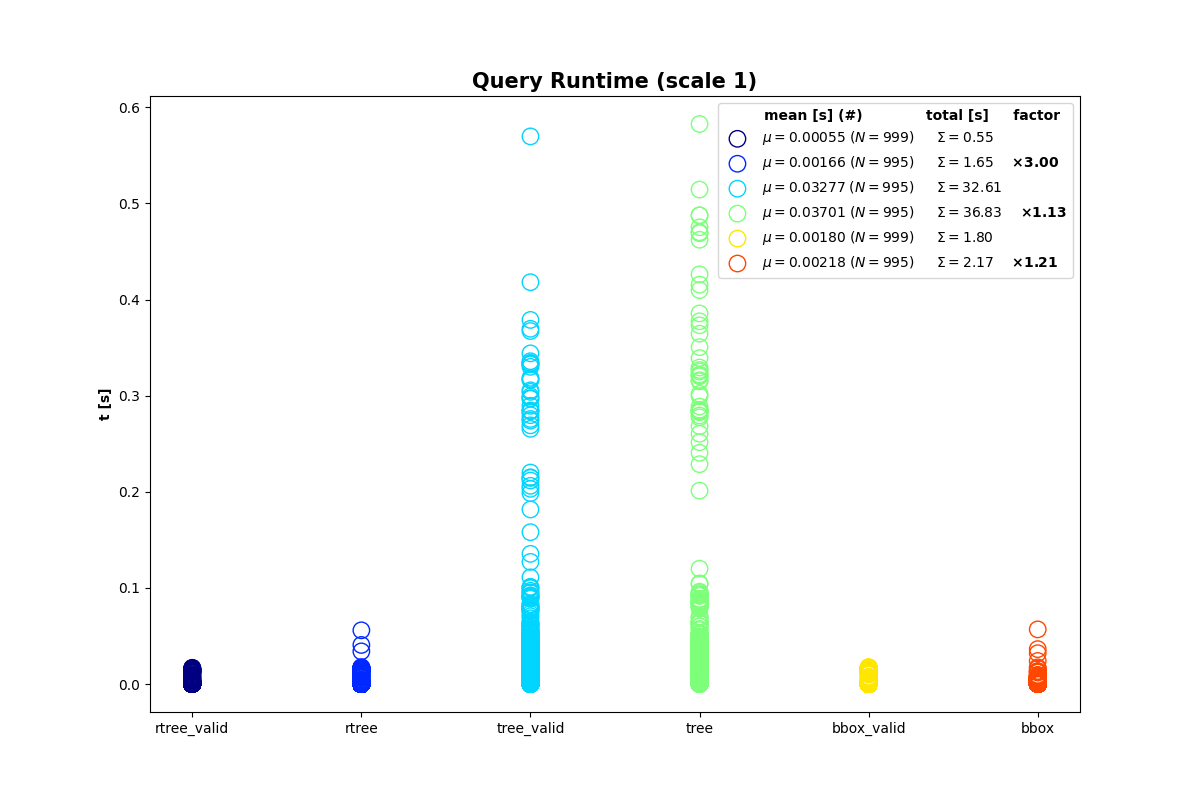

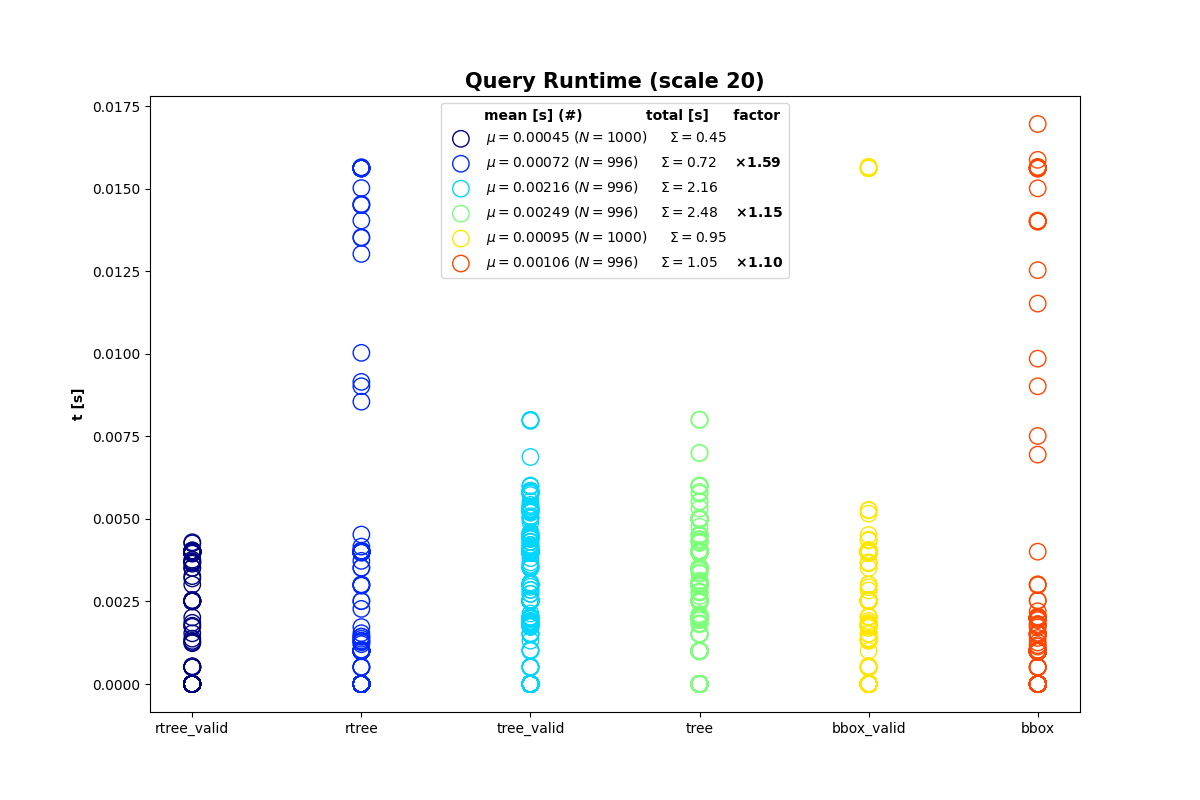

In [43]:
def benchmark_valid_point(nf, N_samples=100, warmup=10, strategies=["rtree", "tree", "bbox"]):

    valid_points = []
    for region in np.random.choice(nf, N_samples+warmup): valid_points.extend(create_random_points(region.geom, 1))
    x = [p[0] for p in valid_points]
    y = [p[1] for p in valid_points]

    plt.figure(figsize=(12, 8))
    durations = [None] * 2 * len(strategies)
    scatters = [None] * 2 * len(strategies)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=2*len(strategies))

    for k, valid_point in enumerate([True, False]):
        for i, strategy in enumerate(strategies):
            durations_ = []
            for j, (x_, y_) in enumerate(zip(x, y)):
                color = matplotlib.cm.jet(norm(2*i + k))

                t0 = time.time()
                hits = nf.find(x_, y_, method=strategy, valid_point=valid_point)
                if not hits: continue
                if j < warmup: continue
                t1 = time.time()

                duration = t1-t0
                durations_.append(duration)

                scatter = plt.scatter(2*i + k, duration, 140, edgecolor=color, facecolor="none", label="_no_label")

            if not durations_: continue

            scatters[2*i + k] = scatter
            durations[2*i + k] = durations_

    for l, (durations_, scatter_) in enumerate(zip(durations, scatters)):
        avg = sum(durations_)/len(durations_)
        if not l%2:
            scatter_.set_label(f"$\mu = {avg:.5f} \; (N={len(durations_)}) \;\;\;\;\;\; \Sigma = {sum(durations_):6.2f}$")
        else:
            scatter_.set_label(f"$\mu = {avg:.5f} \; (N={len(durations_)}) \;\;\;\;\;\; \Sigma = {sum(durations_):6.2f} \;\;\;\;\; \\mathbf{{\\times  {sum(durations_)/sum(durations[l-1]): 6.2f}}}$")


    plt.title(f"Query Runtime (scale {nf.scale})" + (f" valid_point" if valid_point else ""), fontweight="bold", fontsize=15)
    plt.ylabel("t [s]", fontweight="bold")
    plt.xticks(range(2*len(strategies)), [val for pair in zip([strat + "_valid" for strat in strategies], strategies) for val in pair])
    plt.legend(scatters, [scatter.get_label() for scatter in scatters], title="       mean [s] (#)             total [s]     factor", title_fontproperties={"weight": "bold"})

N = 1000
benchmark_valid_point(finders[max_levels.index(max_level)][scales.index("01")], N_samples=N)
benchmark_valid_point(finders[max_levels.index(max_level)][scales.index("20")], N_samples=N)


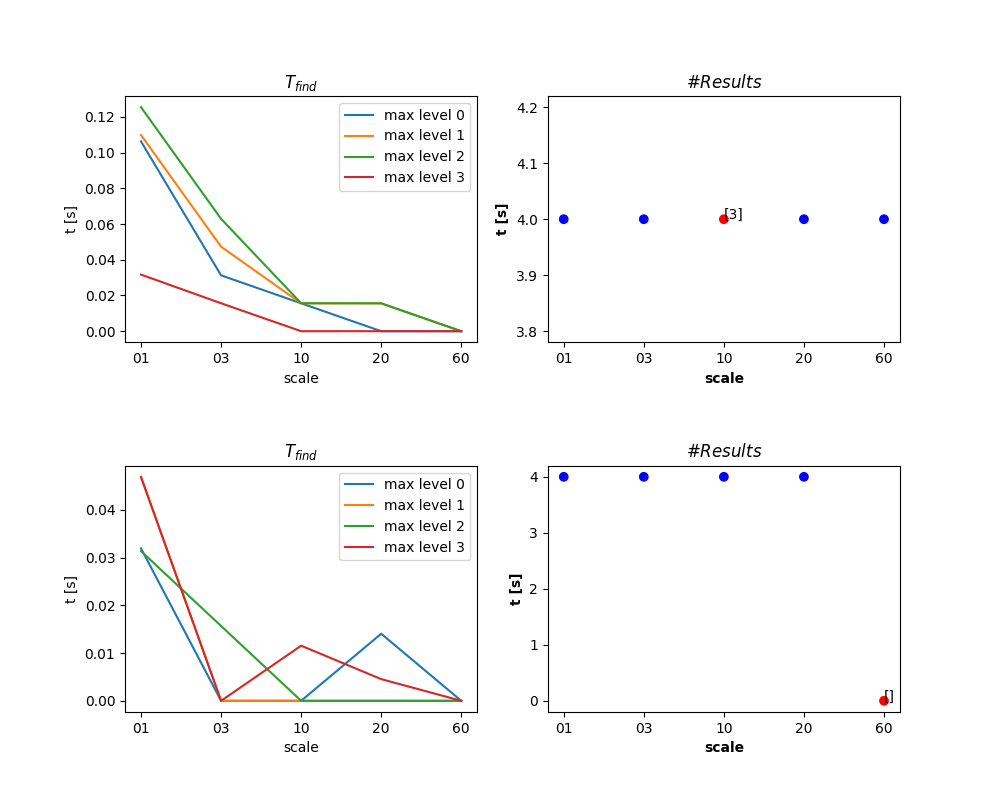

In [44]:
# compare point queries
points = [(-2.865604, 53.406115), (-2.965604, 53.406115)]

fig, axs = plt.subplots(len(points), 2, figsize=(10, 4*len(points)), squeeze=False)
x = range(len(scales))
plt.subplots_adjust(hspace=0.5)
for point, axs_row in zip(points, axs):
    ax_find, ax_results = axs_row
    for maxl, finders_ in zip(max_levels, finders):
        results = []
        times_find = []
        for scale, finder in zip(scales, finders_):
            t1 = time.time()
            f = finder.find(lat=point[1], lon=point[0])
            t2 = time.time()

            times_find.append(t2-t1)
            results.append(f)

        ax_find.plot(x, times_find, label=f"max level {maxl}")
        ax_find.set_xticks(x, scales)
        ax_find.set_xlabel("scale")
        ax_find.set_ylabel("t [s]")
        ax_find.set_title("$T_{find}$")
        ax_find.legend()
    equal = [res == results[0] for res in results]
    color = ["blue" if equ else "red" for equ in equal]
    ax_results.scatter(x, [len(r) for r in results], c=color)
    for equ, x_, res in zip(equal, x, results):
        if not equ:
            wrong = [not results[0][j] == res[j] for j in range(len(res))]
            ax_results.annotate(str([i for i, wr in enumerate(wrong) if wr]), (x_, len(res)))
    ax_results.set_xticks(x, scales)
    ax_results.set_title("$\# Results$")
    ax_results.set_xlabel("scale", fontweight="bold")
    ax_results.set_ylabel("t [s]", fontweight="bold")

In [45]:
results

[[NUTS0: UK, NUTS1: UKD, NUTS2: UKD7, NUTS3: UKD72],
 [NUTS0: UK, NUTS1: UKD, NUTS2: UKD7, NUTS3: UKD72],
 [NUTS0: UK, NUTS1: UKD, NUTS2: UKD7, NUTS3: UKD72],
 [NUTS0: UK, NUTS1: UKD, NUTS2: UKD7, NUTS3: UKD72],
 []]